### Dataset preparation

In [1]:
# Importing required modules
from torch.utils.data import Dataset
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torchvision
from PIL import Image
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt

# Defining OurOwnDataset class
class OurOwnDataset(Dataset):
    def __init__(self, root_folder, transforms=None, train=True):
        self.root_folder = root_folder
        self.transforms = transforms

        # choose type of dataset (train/test)
        annot_name = 'Train.csv' if train else 'Test.csv'
        self.df = pd.read_csv(f'{root_folder}/{annot_name}')

        # keep only 5 first classes (to reduce size of dataset)
        self.df = self.df[self.df['ClassId'] < 5]

        print(f'Found {len(self.df)} images for {annot_name.split(".")[0]} part')

    def __getitem__(self, i):

        path = os.path.join(self.root_folder, self.df['Path'].iloc[i])
        image = cv.imread(path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        if self.transforms:
            image = self.transforms(image)


        label = self.df['ClassId'].iloc[i]
       
        return image, label

    def __len__(self):
        return len(self.df)

Found 2640 images for Test part
Road sign class is 1


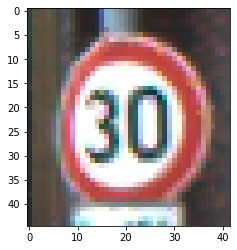

Road sign class is 4


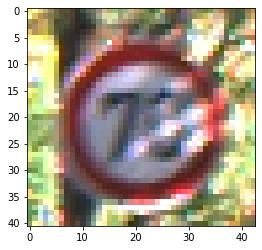

Road sign class is 4


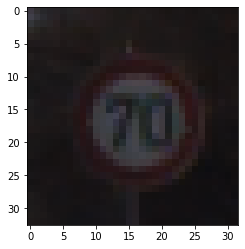

Road sign class is 3


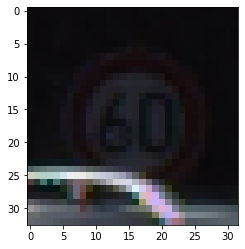

In [2]:
# Testing defined class
dataset = OurOwnDataset('dataset_signs', train=False)

for i in range(4):
    image, label = dataset.__getitem__(i)
    print("Road sign class is {}".format(label))
    plt.imshow(image)
    plt.show()

In [3]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter, ToPILImage, Resize, RandomRotation

target_transforms = Compose([
                             ToPILImage(),
                             # augmentation transformations
                             ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
                             RandomRotation(20),
                             # utility transformations
                             Resize((224, 224)),
                             ToTensor(),
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # "magic numbers" - Imagenet statistics for each channel
])

train_dataset = OurOwnDataset('dataset_signs', transforms=target_transforms, train=True)
valid_dataset = OurOwnDataset('dataset_signs', transforms=target_transforms, train=False)

Found 8070 images for Train part
Found 2640 images for Test part


In [4]:
from torch.utils.data import DataLoader
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)

### Building network

In [7]:
from torch.nn.modules.pooling import MaxPool2d
from torch import nn
import torch

# Creating class for AlexNet
class OurAlexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(*[
                                        nn.Conv2d(3, 96, (11, 11), stride=4, padding=1), # Conv2d(input_dimensions, out_dimensions, kernel_shape, stride=1, padding=0)
                                        nn.ReLU(),  # activation function
                                        nn.MaxPool2d((3, 3), stride=2), # MaxPool2d(kernel_shape, stride=1)
                                        nn.Conv2d(96, 256, (5, 5), padding=2),
                                        nn.ReLU(),
                                        nn.MaxPool2d((3, 3), stride=2),
                                        nn.Conv2d(256, 384, (3, 3), padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(384, 384, (3, 3), padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(384, 256, (3, 3), padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d((3, 3), stride=2),
                                        nn.Flatten() # reshape tensort Batch_size X Channels X Width X Height -> Batch_size X (Channels * Width * Height)
                                        ])
        
        self.classifier = nn.Sequential(*[
                                        nn.Linear(5*5*256, 4096), # Linear(input_dimensions, out_dimensions)
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(4096, 1000), # last out dimension must be equal to number of classes
        ])

    def forward(self, x):
        features = self.feature_extractor(x)
        out = self.classifier(features)
        return out

In [8]:
# Testing defined class
net = OurAlexnet()
res = net(torch.randn((1, 3, 224, 224)))
res.shape

torch.Size([1, 1000])

In [ ]:
for param in net.parameters():
    print(param.shape)

In [ ]:
for x, y in train_dataloader:
    print(net.forward(x))
    print(y)

### Training model

In [ ]:
from torch.optim import SGD
EPOCHS = 3

for epoch in range(EPOCHS):
    # train stage
    net.train()
    #net.cuda()
    #result = net(some_input_tensor)
    #print(net)
    
    for x, y in train_dataloader:
        # Implement Optimization Step
        # Initialization
        optimizer = SGD(params=net.parameters(), lr=1e-3, momentum=0.9)
        # Resetting gradients (required before each weight update)
        optimizer.zero_grad()
        # Optimization step with parameter update
        optimizer.step()

    # evaluation stage
    net.eval()
    for x, y in valid_dataloader:
        # Implement Model Estimation Process
    
    #  Print training state: current epoch, accuracy, sum/mean of loss function

    # (optional) Stop training if there is no improvement

In [ ]:
# Do it here
a = torch.Tensor([1, 2, 3])
a_numpy = a.numpy() # Converting a tensor to a numpy array for visualization
print(a_numpy)